This notebook has been prepared by Hsiu-Wen Chang from MINES ParisTech

# Real-time object tracking with fixed background

Object tracking is a long standing and useful computer vison task. It consists two major research area: detection and tracking. For detecting object on monocular camera, we can further divide and algorithms into three categories: regional-based, anchor based and keypoints methods. Considering the fact that the successful rate of object detection is the key to the success of tracking, we shall start with regional-based method alghough it is relatively slow in inference time.

Algorithms applied in this practical lesson
1. Detectron2 (Mask R-CNN) : pytorch
2. YOLOv3


# Install detectron2

In [ ]:
# install dependencies: 
!pip install pyyaml==5.1 pycocotools>=2.0.1
import torch, torchvision
print(torch.__version__, torch.cuda.is_available())
!gcc --version
# opencv is pre-installed on colab

In [ ]:
# install detectron2: (Colab has CUDA 10.1 + torch 1.6)
# See https://detectron2.readthedocs.io/tutorials/install.html for instructions
assert torch.__version__.startswith("1.6")
!pip install detectron2 -f https://dl.fbaipublicfiles.com/detectron2/wheels/cu101/torch1.6/index.html

In [ ]:
# Some basic setup:
# Setup detectron2 logger
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common libraries
import numpy as np
import os, json, cv2, random
from google.colab.patches import cv2_imshow
from google.colab import files

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer,ColorMode
from detectron2.data import MetadataCatalog, DatasetCatalog

# Run a pre-trained detectron2 model

In [ ]:
# Upload or locate the images or video from local files
#uploaded = files.upload()
#for fn in uploaded.keys():
#  print('User uploaded file "{name}" with length {length} bytes'.format(
#      name=fn, length=len(uploaded[fn])))
#img_list = list(uploaded.keys())
#im = cv2.imread(img_list[0])

# You can find other ways to load a files at https://colab.research.google.com/notebooks/io.ipynb#scrollTo=BaCkyg5CV5jF
!wget https://cloud.mines-paristech.fr/index.php/s/ixTMf8Pu2nThZjb/download -q -O input1.jpg
im = cv2.imread("./input1.jpg")

We first download an image from the Varna dataset: (video is availabe at the end of this colab)

In [ ]:
cv2_imshow(im)

Then, we create a detectron2 config and a detectron2 `DefaultPredictor` to run inference on this image.

Here, we use Mask R-CNN 50 FPN that has 91 categories of objects. Feel free to play other pre-trained model at https://github.com/facebookresearch/detectron2/blob/master/MODEL_ZOO.md

In [ ]:
cfg = get_cfg() # obtain detectron2's default config
# add project-specific config (e.g., TensorMask) here if you're not running a model in detectron2's core library
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5  # set threshold for this model
# Find a model from detectron2's model zoo. You can use the https://dl.fbaipublicfiles... url as well
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")
predictor = DefaultPredictor(cfg)
outputs = predictor(im)

**Qestion 1: what is the backbone of this pre-train model?**

In [ ]:
# look at the outputs. See https://detectron2.readthedocs.io/tutorials/models.html#model-output-format for specification
print(outputs["instances"].pred_classes)
print(outputs["instances"].pred_boxes)

In [ ]:
# We can use `Visualizer` to draw the predictions on the image.
v = Visualizer(im[:, :, ::-1], MetadataCatalog.get(cfg.DATASETS.TRAIN[0]), scale=1.2)
out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
cv2_imshow(out.get_image()[:, :, ::-1])

**Question 2: what is the inference time for one image?**

In this example, you can see we miss the detection of a guy in th middle of the road. DANGEROUS!

Another issue here is the blue car close to the right bottom corner that we missed it. It is not a big issue since it is not on the major road. However, we should keep this in mind that do we need to track the cars that are parked on the street? 

Let's see a troublesome one

In [ ]:
!wget https://cloud.mines-paristech.fr/index.php/s/btteNk7PzRZ2DD2/download -q -O input2.jpg
im2 = cv2.imread("input2.jpg")
outputs2 = predictor(im2)
v = Visualizer(im2[:, :, ::-1], MetadataCatalog.get(cfg.DATASETS.TRAIN[0]), scale=1.2)
out = v.draw_instance_predictions(outputs2["instances"].to("cpu"))
cv2_imshow(out.get_image()[:, :, ::-1])

You should start to see more problems in this image that the detection using pre-trained model is not perfect: <br>
1. Trees could be classified to horse and indeed, do we really need to have this categories?
2. There are many missed detection of pedestrian. 
3. Missed or low confidence of object detection when the objects are partially covered by other things.

In fact, objects in the training images (such as from COCO, ImageNet) usually has high ratio of size/background. However, it is common that the objects in the surveillance video are samller than the images from the image dataset due to the tilt angle of camera, the height of the camera and etc. You are facing a problem called "Detecting small objects in the image". 

# Tasks for you to solve here for detection:
1. Improve the detection rate: how you input the information to neural network?
2. Remove the not-so-interested objects

Before you continue to do tracking of the detected objects, you should try to improve the result of object detection as much as you can. But keep in mind that some of the tracking algorithm can help in detecting the intermittent objects in a short period of time but the goal here is to provide a robust algorithm that should not fail the tracking significantly.  






 # State-of-Art algorithms in detecting small objects APs

 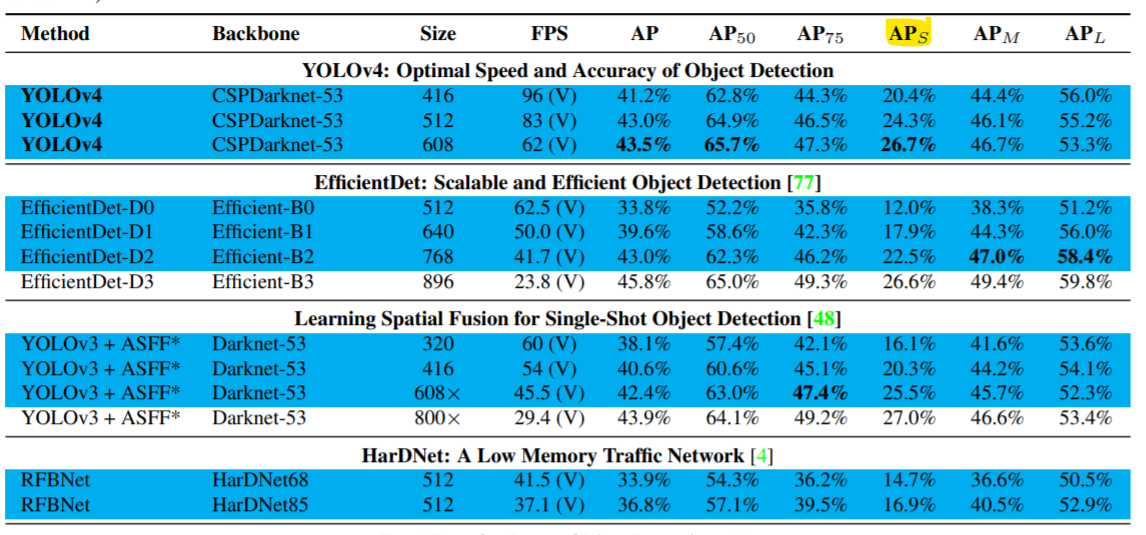


Other ways to improve the result of object detection:
1. Use the pre-trained model and train it on your own dataset: in this case you need to label the Varna video (lableImg: [https://github.com/tzutalin/labelImg]) 
2. Using sliding windows to detect objects in different runs with proper overlapping and cooridnates transformation
3. Switch to YOLOv4 which has auto learning of model anchors [https://github.com/AlexeyAB/darknet]. I can say it is going to be faster but I don't guarantee that it is better in detection :)


# Inference object detection on video
Here is the original video provided for multiple tracking of cars and pedestrian

In [ ]:
# Run frame-by-frame inference demo on video with the "demo.py" tool that detectron provided in the repo.
# First video is an easier one (day time)
# Second video is at night
!wget https://cloud.mines-paristech.fr/index.php/s/T5jgr9KiTV3aaX4/download -q -O video-clip.mp4
!git clone https://github.com/facebookresearch/detectron2


In [ ]:
from IPython.display import Video

Video()

In [ ]:
from IPython.display import display, HTML, Video
from base64 import b64encode
mp4 = open("video-clip.mp4",'rb').read()
data_url = "data:video/mp4;base64," + b64encode(mp4).decode()
HTML("""
<video width=800 controls>
      <source src="%s" type="video/mp4">
</video>
""" % data_url)

In [ ]:
!python detectron2/demo/demo.py --config-file detectron2/configs/COCO-PanopticSegmentation/panoptic_fpn_R_101_3x.yaml --video-input video-clip.mp4 --confidence-threshold 0.6 --output video-output.mkv \
  --opts MODEL.WEIGHTS detectron2://COCO-PanopticSegmentation/panoptic_fpn_R_101_3x/139514519/model_final_cafdb1.pkl

**Question 3: what is total inference time for this video by Detectron 2?**

# Object detection by Yolov3

We can see the Mask-RCNN is slow. For realtime application, for example, traffic monitoring, we need some thing that can run almost real-time. 

YOLO_v3 is currently among the fastest Convolutional Neural Networks for visual objects detection. [To get more information about YOLO_v3, you should go to the official YOLO page of its creator Joseph Redmon: https://pjreddie.com/darknet/yolo/](https://pjreddie.com/darknet/yolo/). Note that the corresponding original implementation is written **in C language** within the [Darknet Open Source Neural Networks C library](https://pjreddie.com/darknet/)

Yolov3 we are going to used here is from Ayoosh Kathuria](https://github.com/ayooshkathuria/pytorch-yolo-v3). Note that this PyTorch implementation of YOLO_v3 is probably slower than the original version compiled from C.

In [4]:
import os
from os.path import exists, join, basename, splitext
import matplotlib
import matplotlib.pyplot as plt

In [ ]:
git_repo_url = 'https://github.com/ayooshkathuria/pytorch-yolo-v3.git'
project_name = splitext(basename(git_repo_url))[0]
if not exists(project_name):
  # clone and install dependencies
  !git clone  $git_repo_url
  #!cd $project_name && pip install -q -r requirement.txt


image_name = './input2.jpg'
print(image_name)
#import wget
if not exists('yolov3.weights'):
  !wget -q https://pjreddie.com/media/files/yolov3.weights

!cd pytorch-yolo-v3 && python detect.py --weights ../yolov3.weights --images ../$image_name --det ..

In [ ]:
plt.figure(figsize=(15, 10))
plt.imshow(matplotlib.image.imread('det_%s' % basename(image_name)))

**Question 3: what is the speed difference and which one is better?**

# (Optional) Evaluation of the performance

## Accuracy of tracking

The metrics accuracy is important to understand the performance of your algorithm. Here are the common metrics you can find:
1. Multiple object tracking precision (MOTP): total position error for matched object hypothesis pairs over all frames, averaged by the total number of matches made. 

2. MOTA: multiple object tracking Accuracy: it is composed of the ratio of misses in the sequence, ratio of false positives and ratio of mismatches. 
 
For more information, read [4]

## Tracking coverage

To know the ability of the coverage all the trajectories, we can use a table like this [1]:
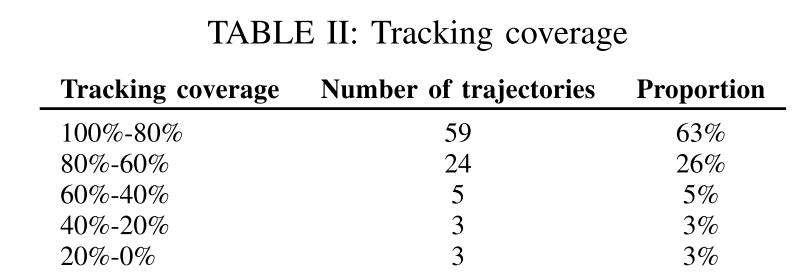

# Mini-project topic 1: track your detected object in time
Tracking detected objects either as bounding box or points, it is not easy to detect them seamlessly. In other words, the algorithm might loss it for a few frames and the objects come back later. How are we going to deal re-entering issue? 

The first idea should be obvous to you that we can create a math model to associate the time frame. This is how in 2016, SORT is proposed to solve the problem by Kalman filter. Then there are several papers start to concentrate on the issue of inference time and re-entering objects. The new algorihm, Centertrack can now generate 3D boxes of objects and track them around 30 FPS rate. You are encouraged to understand this new approach and see what is the outcome on the provided video. 

## Tracking

In real life, we would like to know when and where and even what is the object in the video. This is very improtant for traffic control, security, criminal applications. Tracking algorithms are classified into two ways:

1. Tracking by detection: One nerual network that detect the object and after that we use other independent algorithm to tracks these detected objects in time. For example, SORT [https://github.com/abewley/sort]: recommened because it is in python. There is also an enhanced version call Deep SORT.

2. Joint tracking: one neural network that do all the thing. For example, CenterTrack (State-of-art, [https://github.com/xingyizhou/CenterTrack]): pay attention that you need to compile DCNv2 (deformable convolution network) 


# Reference
1.   Clausse, A., Benslimane, S., & De La Fortelle, A. (2019). Large-scale extraction of accurate vehicle trajectories for driving behavior learning. IEEE Intelligent Vehicles Symposium, Proceedings, 2019-June, 2391–2396.
2.   Bochkovskiy, A., Wang, C.-Y., & Liao, H.-Y. M. (2020). YOLOv4: Optimal Speed and Accuracy of Object Detection.
3.   Zhou, X., Koltun, V., & Krähenbühl, P. (2020). Tracking Objects as Points. http://arxiv.org/abs/2004.01177
4. K. Bernardin and R. Stiefelhagen (2008). Evaluating multiple object tracking performance: The clear mot metrics. EURASIP Journal on Image and Video Processing, vol. 2008, p. 246309

